In [1]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import math
import copy
import random
from dataclasses import dataclass

In [3]:
from algo.dynamicProgramming import dynamicPlayer
from algo.iplayer import RandomPlayer, IPlayer
from algo.q_learning import QLearning
from algo.board import Board, GameState

In [4]:
device = torch.device(
    # "cuda" if torch.cuda.is_available() else
    # "mps" if torch.backends.mps.is_available() else
    "cpu"
)
device

device(type='cpu')

In [5]:
class DQN(nn.Module):
	"""
	Using structure similar to NNUE:
	https://www.chessprogramming.org/File:StockfishNNUELayers.png
	
	Observation space: hot-encoded board:
	for each of 18 cells we can be -2, -1, 0, 1, 2 (5 possibilities).
	In total it gives 18 * 5 = 90 possible inputs, out of which at most 12 are on.
	
	# Action space: 4 possible actions.
	Value function: 1 output. # https://www.reddit.com/r/reinforcementlearning/comments/1b1te73/help_me_understand_why_use_a_policy_net_instead/
	"""

	def __init__(self):
		super(DQN, self).__init__()

		layer_sizes = [
			90,
			52,
			1
		]

		layers = []
		prev_size = layer_sizes[0]
		for cur_size in layer_sizes[1:]:
			layers.append(nn.Linear(prev_size, cur_size))
			prev_size = cur_size

		self.layers = nn.ModuleList(layers)

	def forward(self, board: Board) -> torch.Tensor:
		state = board.to_tensor(device)
		for layer in self.layers[:-1]:
			state = F.relu(layer(state))
		return self.layers[-1](state)

In [6]:
def make_environment_step(state: Board, action: tuple[tuple[int, int], tuple[int, int]], enemy: IPlayer) -> tuple[Board, torch.Tensor]:
	"""
	Returns new state and reward for the given action.
	"""
	state = copy.deepcopy(state)
	cur_sign = state.turn_sign
	we_captured = bool(state.make_move(*action).captured) * cur_sign
	reward = 0

	for pos, piece in state:
		if (cur_sign == 1 and piece == 2 and pos[1] > 3) or \
			(cur_sign == -1 and piece == -2 and pos[1] < 2):
			reward -= 1

	enemy_captured = 0
	while state.game_state == GameState.NOT_OVER and state.turn_sign != cur_sign:
		enemy_captured += bool(state.make_move(*enemy.decide_move(state)).captured) * cur_sign * (-1)
		
	reward += we_captured - enemy_captured
	if state.game_state != GameState.NOT_OVER:
		our_pieces = 0
		enemy_pieces = 0
		for _, piece in state:
			if piece == cur_sign:
				our_pieces += 1
			elif piece == -cur_sign:
				enemy_pieces += 1
			elif piece == 2 * cur_sign:
				our_pieces += 2
			elif piece == -2 * cur_sign:
				enemy_pieces += 2
			
		reward += 3 * our_pieces / (enemy_pieces + 1)

		if state.game_state == GameState.DRAW:
			reward -= 40
		elif state.game_state == GameState(cur_sign):
			reward += 40
		elif state.game_state == GameState(-cur_sign):
			reward -= 40
		else:
			raise ValueError("Unexpected game state")
	
	return state, torch.Tensor([reward])

In [7]:
GAMMA = 0.99 # discount rate

@dataclass
class Action:
	action: tuple[tuple[int, int], tuple[int, int]]
	value: torch.Tensor

def q_s(dqn: DQN, current_state: Board) -> list[Action]:
	"""
	Return: list[(new_state, action, immediate_reward, value)]
	"""
	ret: list[Action] = []
	for s in current_state.get_possible_pos():
		for e in current_state.get_correct_moves(s):
			next_state = copy.deepcopy(current_state)
			immediate_reward = torch.tensor([bool(next_state.make_move(s, e).captured) * next_state.turn_sign], device=device)
			value = dqn(next_state) * GAMMA + immediate_reward
			ret.append(Action((s, e), value))
	return ret

In [8]:
BATCH_SIZE = 50 # number of transitions sampled from the replay buffer

EPS_START = 0.9 # exploration rate
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.009 # update rate
LR = 1e-2 # AdamW learning rate

policy_net = DQN().to(device) # to be updated often
target_net = DQN().to(device) # to be updated with TAU
policy_net.load_state_dict(torch.load("dqn_y87_90_52_1.pth"))
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
steps_done = 0


def select_action(board: Board) -> Action:
	global steps_done
	sample = random.random()
	eps_threshold = EPS_END + (EPS_START - EPS_END) * \
		math.exp(-1. * steps_done / EPS_DECAY)
	steps_done += 1
	if sample > eps_threshold:
		with torch.no_grad():
			state_values = q_s(policy_net, board)
			return max(state_values, key=lambda x: x.value.item())
					
	else:
		possible_moves = []
		for s in board.get_possible_pos():
			for e in board.get_correct_moves(s):
				possible_moves.append((s, e))
		return Action(
			random.choice(possible_moves),
			torch.tensor([0], device=device)
		)

C:\Users\pytorchUser\AppData\Local\Temp\ipykernel_123228\3614281122.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load("90_52_1_8749,

(array([1.0900e+02, 2.8280e+03, 2.8830e+03, 6.6540e+03, 0.0000e+00,
        1.0213e+04, 1.9361e+04, 6.5230e+03, 1.4260e+03, 3.0000e+00]),
 array([-7. , -5.4, -3.8, -2.2, -0.6,  1. ,  2.6,  4.2,  5.8,  7.4,  9. ]),
 <BarContainer object of 10 artists>)

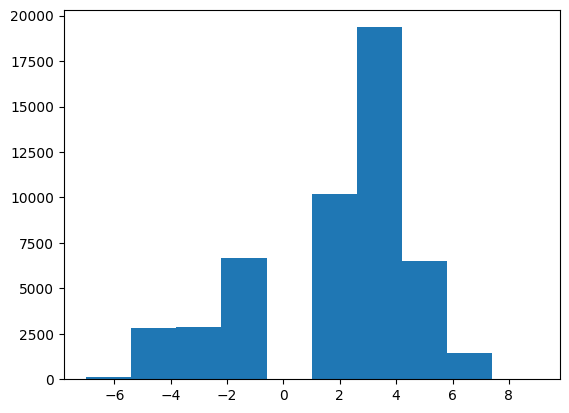

In [9]:
stats = []

# enemy = QLearning("90_52_1_9130.pth", [90, 52, 1])

for i in range(50000):
	enemy = RandomPlayer(i)
	board = Board()
	while board.game_state == GameState.NOT_OVER:
		while board.game_state == GameState.NOT_OVER and board.turn_sign == 1:
			board.make_move(*enemy.decide_move(board))
		while board.game_state == GameState.NOT_OVER and board.turn_sign == -1:
			with torch.no_grad():
				state_values = max(q_s(target_net, board), key=lambda x: x.value.item())
				board.make_move(*state_values.action)
		# while board.game_state == GameState.NOT_OVER and board.turn_sign == -1:
		# 	board.make_move(*enemy.decide_move(board))
	
	pieces = 0
	for _, piece in board:
		pieces += piece != 0
	
	result = (1 if board.game_state == GameState(-1) else -1) * abs(pieces)
	
	stats.append(result)


from matplotlib import pyplot as plt

plt.hist(stats)

In [10]:
sum(1 for x in stats if x > 0) / len(stats)

0.75052

In [11]:
import pickle
with open("dqn_y87_90_52_1.pkl", "wb") as f:
	pickle.dump(stats, f)

In [12]:
sum(stats) / len(stats)

np.float64(1.87518)